# Multivariate curve resolution (MCR)

Next to its preprocessing, plotting and supervised calibration functionalities, chemometrics is also useful for the unsupervised factorization of data. In this example, multivariate curve resolution (MCR) is used to decompose Raman spectra of carbohydrate mixtures into single component concentrations. MCR factorizes a spectral data set $D$ into concentration $\hat C$ and spectra $\hat S$ estimates such that constraints both on $\hat C$ and $\hat S$ are fulfilled. Typical constraints are non-negativity, magnitude of the estimated vectors andunimodality, among others. Mathematically speaking:

$$\min||D - \hat C\hat S^T ||$$
such that e.g. $$\hat C, \hat  S > 0$$, 


MCR is especially useful, if we have additional information on how the concentration profiles or the spectra should look like.

For this example, we first need to load the required packages. numpy is used for matrix handling, matplotlib for plotting and pandas for importing the data. From chemometrics, we import the main package `chemometrics`, the MCR transformer class (`chemometrics.mcr.McrAR`) and MCR constraints (`chemoemtrics.mcr.constraint`). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# chemometrics
import chemometrics as cm
from chemometrics.mcr import McrAR
import chemometrics.mcr.constraint as constraint

The data is provided in three csv-files. 'carbs_D.csv' contains the spectra of mixtures of three carbohydrates, 'carbs_C.csv' contains the volume fractions of the three carbohydrates and 'carbs_S.csv' contains the pure component spectra. The three carbohydrates are 1) fructose, 2) lactose, 3) ribose. The original carbohydrate spectra were published as [SPECARB](http://www.models.life.ku.dk/~specarb/specarb.html) and subsequently mixed *in silico*, combined with Gaussian noise and published as part of the R library [mdatools](https://github.com/svkucheryavski/mdatools).

We are relying on the `read_csv` functionality of pandas to read the data. The data is then converted to pure numpy arrays such that they can be processed with chemometrics and scikit-learn.

In [3]:
# prepare file names for loading
files = ['carbs_D.csv', 'carbs_C.csv', 'carbs_S.csv']

# import data into dict
data = {}
for file in files:
    data[file] = pd.read_csv(file, index_col=0)

# convert to numpy array for easy handling with chemometrics
D, C, S = [data[key].values for key in data]

# store wavenumbers and names of used carbohydrates
wavenumbers = pd.to_numeric(data[files[0]].columns.values)
substance_names = data[files[2]].columns

Typically, in case of MCR, we would not have the actual component concentrations available. However, since we are working with artificial data and to get a feeling on the underlying differences in the spectra, the spectra colored by the reference concentration are plotted below. We can plot them by relying on `chemometrics.plot_colored_series` for the coloring by reference concentration. 

Based on the plotted spectra, we see that we have peaks associated with our component but for most peaks there is an overlap with peaks from the other two components. This is a situation where MCR is useful. MCR factorizes the data while taking into account certain constraints. Finally, we obtain the estimates of the pure spectra `S` and get an estimate of the volume fraction `C` of the components used in the system.

Text(0, 0.5, 'Intensity / AU')

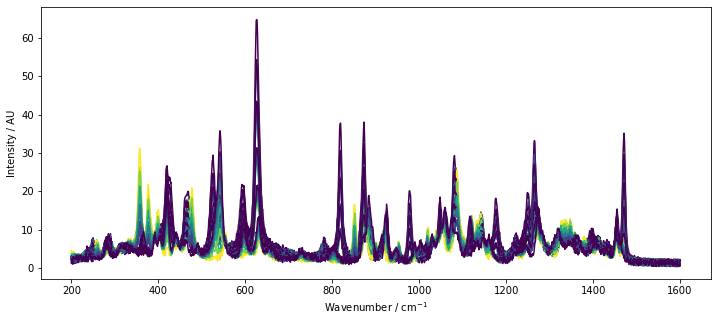

In [4]:
plt.figure(figsize=[12, 5])

lines = cm.plot_colored_series(D.T, x=wavenumbers, reference=C[:, 1])

plt.xlabel(r'Wavenumber / $\mathrm{cm^{-1}}$')
plt.ylabel('Intensity / AU')

## Selecting the number of components

For real-world data, we often don't know how many components contribute to the spectra. The MCR implementation of chemometrics requires us to provide the number of components when factorizing data. The most straight-forward approach to estimate the number of components for new data is to use a PCA or an SVD and investigate, how much variance is explained by how many components. In chemometrics, we can use the `cm.plot_svd` function to get a quick overview of the singular vectors and the eigenvalues, former corresponding to the composition and spectra, latter corresponding to the explained variance.

After executing the function with our data, we get three plots sumarizing the first three eigenvectors (left and right plot) as well as the eigenvalues (center plot). If we look at the eigenvalues, we can clearly see that three components are necessary to describe the spectra adequatly. After the first three components, there is a steep drop in the magnitude of eigenvalues with a subsequent plateau (L-shaped curve). The horizontal part of the L is typically considered to be due to measurement noise. We can thus proceed towards fitting an MCR model with three independent components.

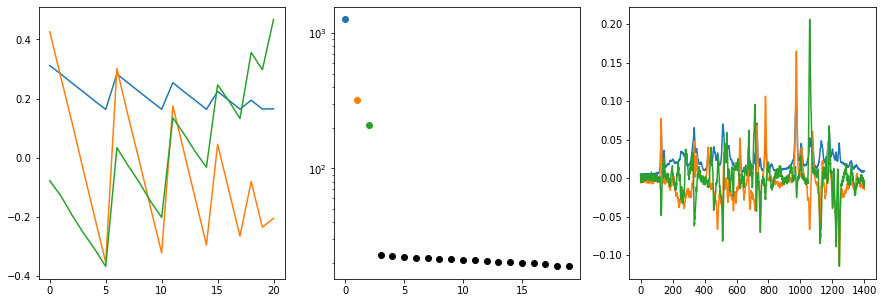

In [16]:
cm.plot_svd(D,n_comp=3)

## Fitting an MCR model

For fitting the MCR model, we need to generate an initial concentration estimate (technically, we could also use a spectral estimate - the procedure would be the same). For a reliable convergence of the algorithm as implemented in chemometrics, it is important to select a reasonable starting estimate of `C`. As observed above, we will need three components to describe the variance in the data. We will use the output of a truncated SVD. However, since the left singular matrix contains negative entries, we are taking the absolut values of the vector and scaling it, such that the left singular matrix largest entry is 1.

In [12]:
# construct initial concentration estimate
from sklearn.decomposition import TruncatedSVD
c_init = np.abs(TruncatedSVD(n_components=3).fit_transform(D))
c_init /= np.max(c_init)

With our initial estimate for `C`, we can now initialize `McrAR`. As constraints, we use non-negativity `constraint.Nonneg` for the concentration estimate as well as the spectral estimate. Additionally, to fix the scaling, we set a normalization constraint for the concentration vector `constraint.Normalizer`. After initialization, the MCR transformer is fitted to the data set `D`. To inspect the result, the fitted spectra (red) are plotted below with the pure spectra (black and grey). The results show a very good overlap of the estimated spectra and the pure component spectra.

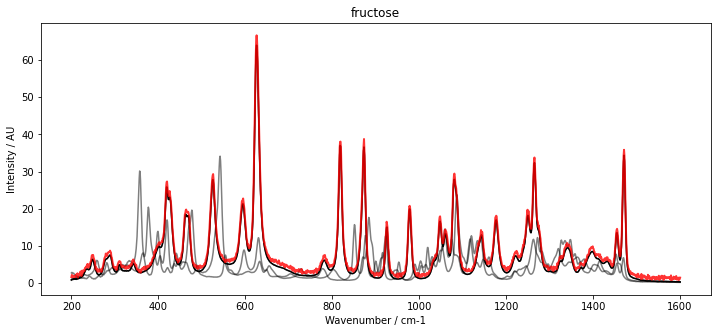

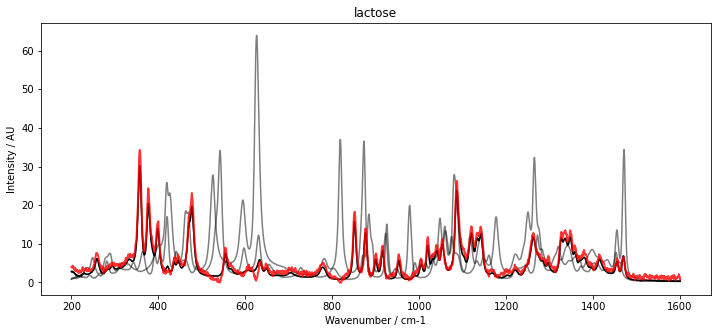

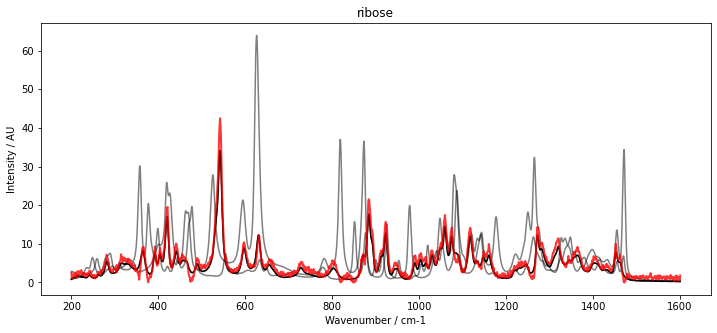

In [13]:
# generate and fit MCR model
mcr = McrAR(c_constraints=[constraint.Nonneg(), constraint.Normalizer()], st_constraints=[constraint.Nonneg()])
mcr.fit(D, C=c_init)

for i in range(3):
    plt.figure(figsize=[12, 5])
    plt.plot(wavenumbers, S[:, i], 'k')
    plt.plot(wavenumbers, S, 'k', alpha=0.5)
    plt.plot(wavenumbers, mcr.ST_.T[:, i], 'r', alpha=0.8, linewidth=2)
    plt.ylabel('Intensity / AU')
    plt.xlabel('Wavenumber / cm-1')
    plt.title(substance_names[i])

We may also use the `McrAR` transformer for concentration predictions. This is done with the `transform` method. The method may either be used for the training data or also for an independent prediction data set. Below, the training data was transformed and compared to the true concentrations in an observed vs predicted plot. A systematic bias is visible for the predictions especially of lactose and ribose. However, for an unsupervised prediction, the result is convincing. It is also worth noting that the transform method is very fast since it does not rely on an iterative approach but predicts the concentrations directly with a least square fit and the application of the constraints.

Text(0, 0.5, 'Predicted')

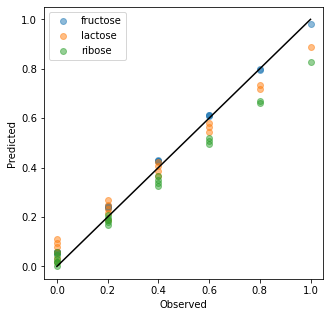

In [15]:
c_estimate = mcr.transform(D)
plt.figure(figsize=[5,5])

for i in range(3):
    plt.scatter(C[:, i],c_estimate[:, i], alpha=0.5)

plt.plot([0,1],[0,1], 'k')
plt.legend(substance_names)
plt.xlabel('Observed')
plt.ylabel('Predicted')

In summary, this example demonstrated, how MCR may be used for the unsupervised factorization of spectroscopic data sets. It showed, how the number of components is chosen, how the `McrAR` fit is performed and the results of the fit and transform of a toy dataset. An adequate fit was obtained with little effort with McrAR.